In [ ]:
!pip install tensorflow-addons

     |████████████████████████████████| 686kB 8.3MB/s 


In [ ]:
from tensorflow import keras
from tensorflow.image import resize
import requests
import librosa
import tarfile
import os
import matplotlib.pyplot as plt
import numpy as np
import IPython
from librosa.display import specshow
import tensorflow_addons as tfa
from PIL import Image

In [ ]:
digits = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

In [ ]:
amount = []
for digit in digits:
    length = len(os.listdir('/content/drive/MyDrive/Datasets/spokendigits/'+digit))
    print(digit, ": ", length)
    amount.append(length)

zero :  2376
one :  2370
two :  2373
three :  2356
four :  2371
five :  2357
six :  2369
seven :  2377
eight :  2352
nine :  2364


In [ ]:
categories = 10
to_res = (224, 224)
input_shape = (256, 256, 3)

model = keras.Sequential()
model.add(keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))

model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))

model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'))
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(tfa.layers.AdaptiveAveragePooling2D(1))


model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(10, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 30, 128)       7

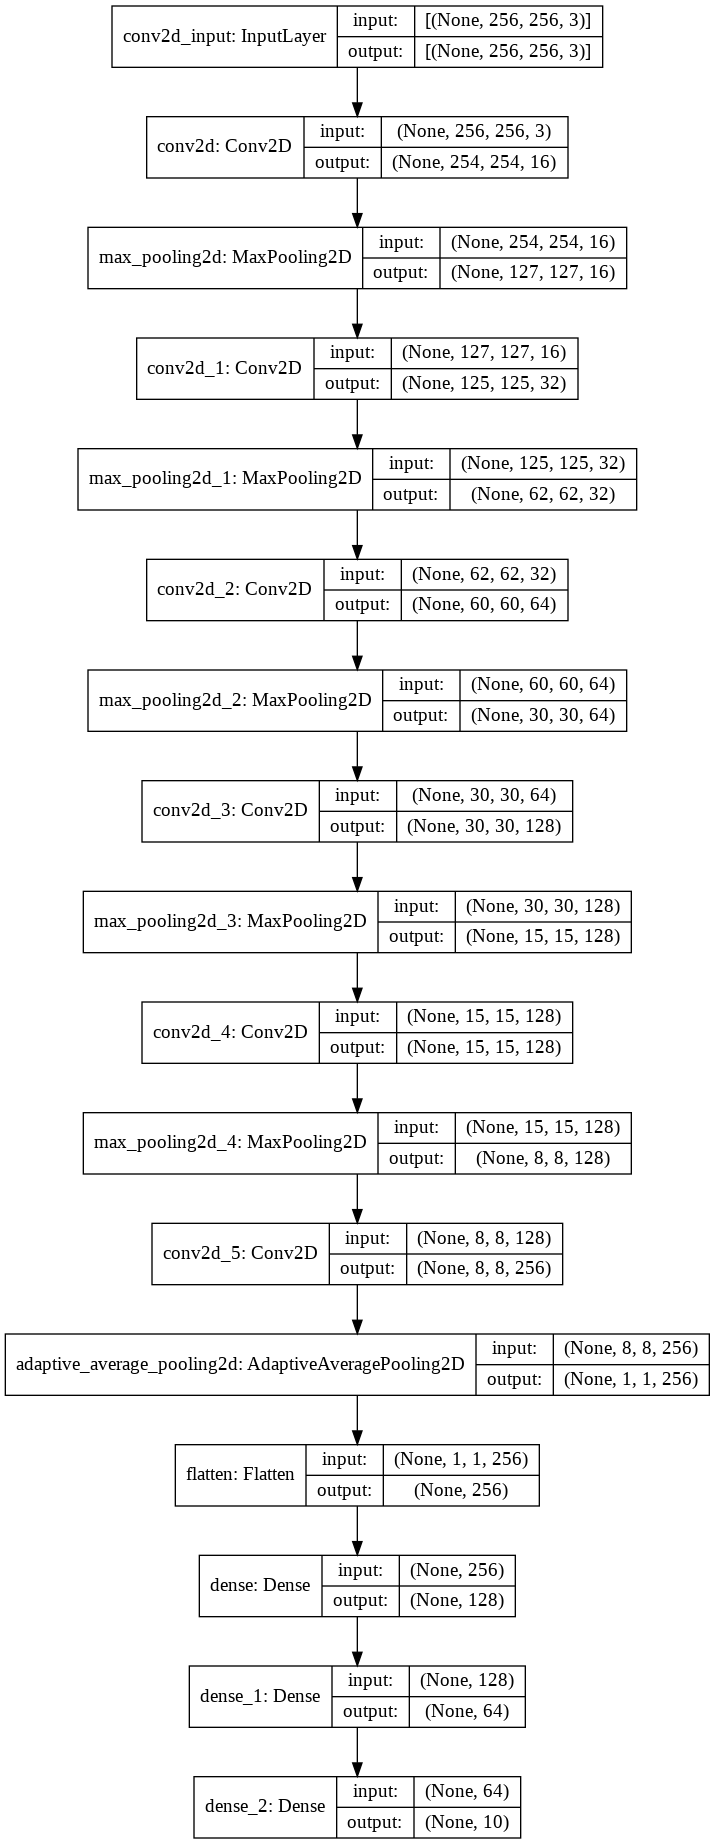

In [ ]:
dot_img_file = '/model_1.png'
keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [ ]:
dir = '/content/drive/MyDrive/Datasets/spokendigits/'
batch_size = 32
img_height = 256
img_width = 256

train_ds = keras.preprocessing.image_dataset_from_directory(
  dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size,
  class_names=digits,)

val_ds = keras.preprocessing.image_dataset_from_directory(
  dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size,
  class_names=digits,)

Found 23665 files belonging to 10 classes.
Using 18932 files for training.
Found 23665 files belonging to 10 classes.
Using 4733 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']


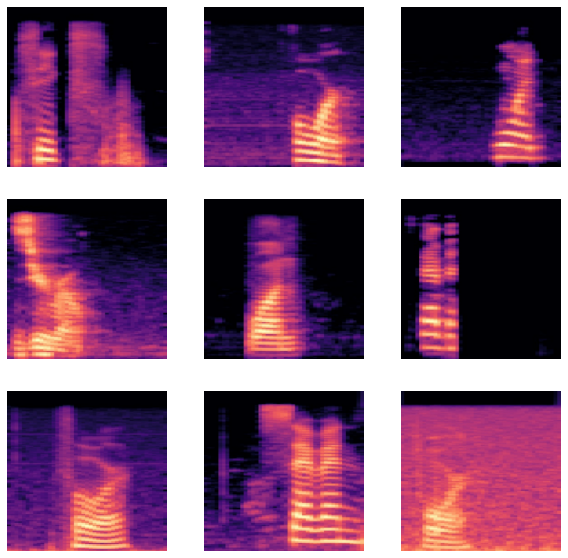

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.squeeze(images[i].numpy().astype("uint8")))
    #plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
normalization_layer = keras.layers.experimental.preprocessing.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(train_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(train_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0
0.0 1.0


In [ ]:
check_point = keras.callbacks.ModelCheckpoint(filepath='lifas-cp.h5',
                                              monitor= 'val_accuracy',
                                              mode='max',
                                              save_best_only=True)

In [ ]:
es = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [ ]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=100,
                    verbose=1,
                    callbacks=[check_point, es])

model.save('lifas.h5')

Epoch 1/100
 77/592 [==>...........................] - ETA: 41:22 - loss: 2.3031 - accuracy: 0.1043

KeyboardInterrupt: ignored

In [ ]:
model.save('lifas-cnn-Adam-96.h5')

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
test_ds = keras.preprocessing.image_dataset_from_directory(
  dir,
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size,
  class_names=digits)

y_pred = model.predict(test_ds)
print(y_pred)
#matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))